<a href="https://colab.research.google.com/github/rithikkulkarni/Video-Virality/blob/main/notebooks/classification_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🚀 YouTube Video Virality – Binary Classification
This notebook builds classification models to predict whether a YouTube video will go **viral (1)** or **not viral (0)** using image and text-based features.


In [8]:
import pandas as pd

url = "https://raw.githubusercontent.com/rithikkulkarni/Video-Virality/refs/heads/main/data/video_details_v8.csv"
df = pd.read_csv(url)
df.head()
df.columns
# df = df.groupby('channel_id').sample(n=100, random_state=42)

Index(['channel_id', 'description', 'tags', 'title', 'avg_red', 'avg_green',
       'avg_blue', 'brightness', 'contrast', 'video_id', 'viewCount',
       'likeCount', 'commentCount', 'title_sentiment', 'title_subjectivity',
       'has_question', 'has_exclamation', 'starts_with_keyword',
       'title_length', 'word_count', 'punctuation_count',
       'uppercase_word_count', 'percent_letters_uppercase', 'has_numbers',
       'clickbait_score', 'viral', 'description_length',
       'description_sentiment', 'description_has_keywords', 'tag_count',
       'tag_sentiment', 'num_unique_tags', 'title_embedding',
       'embedding_distance_to_known_viral', 'title_readability',
       'title_embedding_distance_to_viral', 'dominant_color_hue',
       'thumbnail_edge_density', 'viewCount_log', 'likeCount_log',
       'commentCount_log'],
      dtype='object')

In [9]:
from sklearn.model_selection import StratifiedKFold, cross_validate
from sklearn.metrics import roc_auc_score, precision_score, recall_score, roc_curve
from sklearn.preprocessing import StandardScaler
from imblearn.pipeline import Pipeline as ImbPipeline
from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
import numpy as np

X = df.drop(columns=["video_id", "title", "channel_id",
    "viewCount", "likeCount", "commentCount", "viral", "description", "tags", "title_embedding", "viewCount_log", "likeCount_log", "commentCount_log"])
y = df['viral']

# Scale features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [10]:
X.columns

Index(['avg_red', 'avg_green', 'avg_blue', 'brightness', 'contrast',
       'title_sentiment', 'title_subjectivity', 'has_question',
       'has_exclamation', 'starts_with_keyword', 'title_length', 'word_count',
       'punctuation_count', 'uppercase_word_count',
       'percent_letters_uppercase', 'has_numbers', 'clickbait_score',
       'description_length', 'description_sentiment',
       'description_has_keywords', 'tag_count', 'tag_sentiment',
       'num_unique_tags', 'embedding_distance_to_known_viral',
       'title_readability', 'title_embedding_distance_to_viral',
       'dominant_color_hue', 'thumbnail_edge_density'],
      dtype='object')

In [11]:
cv = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

models = {
    "XGBoost": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", XGBClassifier(
            scale_pos_weight=(sum(y == 0) / sum(y == 1)),
            use_label_encoder=False,
            eval_metric="logloss",
            random_state=42))
    ]),
    "SMOTE + Random Forest": ImbPipeline([
        ("smote", SMOTE(random_state=42)),
        ("clf", RandomForestClassifier(n_estimators=100, random_state=42))
    ])
}


🔍 XGBoost – 10-Fold Cross-Validation


/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:20] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_encoder" } are not used.

  warnings.warn(smsg, UserWarning)
/usr/local/lib/python3.11/dist-packages/xgboost/core.py:158: UserWarning: [17:28:21] WARNING: /workspace/src/learner.cc:740: 
Parameters: { "use_label_e

Precision: 0.931
Recall: 0.990
ROC AUC: 0.997

Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.994     0.997      1191
           1      0.931     0.990     0.960        96

    accuracy                          0.994      1287
   macro avg      0.965     0.992     0.978      1287
weighted avg      0.994     0.994     0.994      1287



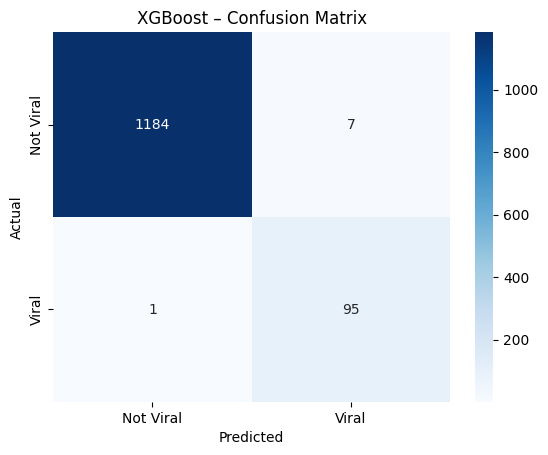


🔍 SMOTE + Random Forest – 10-Fold Cross-Validation
Precision: 0.931
Recall: 0.990
ROC AUC: 0.999

Classification Report:
              precision    recall  f1-score   support

           0      0.999     0.994     0.997      1191
           1      0.931     0.990     0.960        96

    accuracy                          0.994      1287
   macro avg      0.965     0.992     0.978      1287
weighted avg      0.994     0.994     0.994      1287



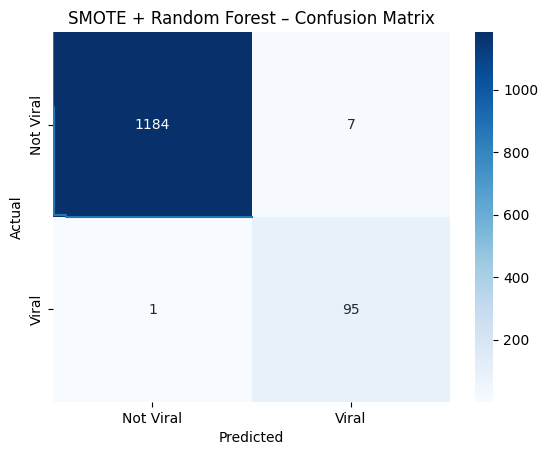

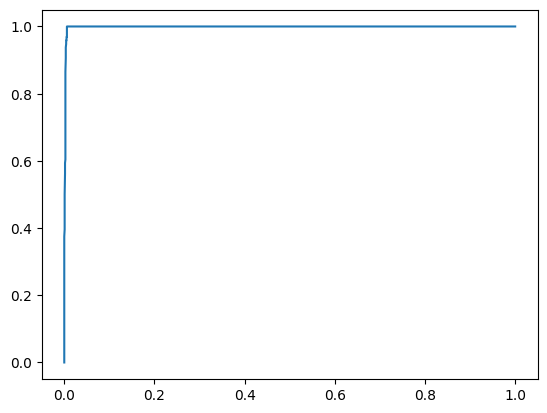

In [12]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import classification_report, confusion_matrix

for name, pipeline in models.items():
    print(f"\n🔍 {name} – 10-Fold Cross-Validation")

    # Collect predictions and probabilities via CV
    preds = cross_val_predict(pipeline, X_scaled, y, cv=cv, method='predict')
    probs = cross_val_predict(pipeline, X_scaled, y, cv=cv, method='predict_proba')[:, 1]

    # Evaluation metrics
    precision = precision_score(y, preds)
    recall = recall_score(y, preds)
    roc_auc = roc_auc_score(y, probs)

    print(f"Precision: {precision:.3f}")
    print(f"Recall: {recall:.3f}")
    print(f"ROC AUC: {roc_auc:.3f}")
    print("\nClassification Report:")
    print(classification_report(y, preds, digits=3))

    # Confusion Matrix
    cm = confusion_matrix(y, preds)
    import seaborn as sns
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["Not Viral", "Viral"], yticklabels=["Not Viral", "Viral"])
    plt.title(f"{name} – Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

    # ROC Curve
    fpr, tpr, _ = roc_curve(y, probs)
    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.2f})")